In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from load_data import FD001_dataset
from visualize_modified import visualize
from RUL_model import RUL_Model, RUL_Model_LearnableStates
from torch.utils.tensorboard import SummaryWriter
from typing import Optional, Tuple, List
from tqdm.auto import tqdm
from train_model import train_model, evaluate_data

# Check if MPS is available and built
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    # Fallback for systems with NVIDIA GPUs (though less relevant on a Mac)
    device = torch.device("cuda")
    print("Using CUDA")
else:
    device = torch.device("cpu")
    print("MPS or CUDA not available, using CPU")

DATA_DIR_PATH = '../CMAPSSData/'

import plotly.express as px
import plotly.io as pio
# pio.templates.default = "none"
pio.templates.default = "plotly_dark"

RUL_UPPER_BOUND = 130  # UPPER BOUND OF RUL

Using MPS (Apple Silicon GPU)


In [2]:
# *** Define a padding index for labels ***
# This value MUST be ignored by your loss function.
# For nn.CrossEntropyLoss, use its 'ignore_index' parameter (default -100 is common).
# Choose a value that doesn't conflict with valid label indices/values.
LABEL_PADDING_IDX = -1000000

def pad_collate_fn_time_step_level(batch):
    sequences = [item[0] for item in batch]
    # Labels are also sequences now
    labels = [item[1] for item in batch] # e.g., list of tensors of shape [Li] or [Li, C]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long) # Lengths based on input sequences

    # Pad features (input sequences)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    # *** Pad labels (label sequences) ***
    # Use the dedicated label padding index!
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=LABEL_PADDING_IDX)

    return padded_sequences, lengths, padded_labels

# Usage:
# train_loader = DataLoader(..., collate_fn=pad_collate_fn_time_step_level)

In [3]:
def plot_rul_vs_time(unit_nr, model, dataloader):
    """
    Plot the RUL over time for a given unit number.
    """
    X, true_rul = dataloader.dataset[unit_nr - 1]
    
    model.eval()
    predicted_rul = model(X).detach().numpy().squeeze(0)

    fig = px.line(
        x=np.arange(1, len(true_rul) + 1),
        y=true_rul.reshape(-1),
        title=f'RUL Over Time: Unit {unit_nr}',
        labels={'x': 'Time', 'y': 'RUL'},
        markers=False
    )
    fig.add_scatter(
        x=np.arange(1, len(predicted_rul) + 1),
        y=predicted_rul.reshape(-1),
        mode='lines',
        name='Predicted RUL'
    )
    fig.update_layout(
        legend=dict(yanchor="bottom",
                    y=0.1,
                    xanchor="left",
                    x=0.1)
    )
    fig.show()
    

In [4]:
import re

def create_hparam_string(hparams):
  """
  Generates a concise file string representation from a hyperparameter dictionary.

  Args:
    hparams (dict): A dictionary containing hyperparameters.

  Returns:
    str: A formatted string summarizing the hyperparameters, suitable for filenames.
         Returns an empty string if the input is not a dictionary or is empty.
  """
  if not isinstance(hparams, dict) or not hparams:
    print("Warning: Input must be a non-empty dictionary.")
    return ""

  parts = []

  # Define abbreviations for keys to keep the string short
  abbreviations = {
      'LearningRate': 'LR',
      'BatchSize': 'BS',
      'HiddenSizes': 'HS',
      'LayerSizes': 'LS',
      'DropoutRate': 'DR',
      'LossFn': 'LF',
      'Optimizer': 'Opt',
      'LearnableStates': 'LrnS'
      # Add more abbreviations as needed
  }

  # Define the order in which parameters should appear in the string
  param_order = [
      'LearningRate', 'BatchSize', 'HiddenSizes', 'LayerSizes', 'DropoutRate',
      'LossFn', 'Optimizer', 'LearnableStates'
  ]

  for key in param_order:
      if key in hparams:
          value = hparams[key]
          abbr = abbreviations.get(key, key) # Use abbreviation if available, else full key

          # Format value based on its type
          if isinstance(value, list):
              # Join list elements with a hyphen
              value_str = '-'.join(map(str, value))
          elif isinstance(value, bool):
              # Use T/F for boolean values
              value_str = 'T' if value else 'F'
          elif isinstance(value, float):
              # Format float to avoid excessive decimal places and replace '.' with 'p'
              value_str = f"{value:.1e}".replace('.', 'p').replace('+','') # e.g., 0.001 -> 1e-03 -> 1e-03
          else:
              # Use string representation for other types
              value_str = str(value)

          # Sanitize value string for filename compatibility (remove potentially problematic characters)
          # Allows alphanumeric, hyphen, underscore, period
          # value_str = re.sub(r'[^\w\-._]+', '', value_str)

          parts.append(f"{abbr}_{value_str}")

  # Add any parameters from hparams that were not in param_order
  for key, value in hparams.items():
      if key not in param_order:
          abbr = abbreviations.get(key, key)
          if isinstance(value, bool):
              value_str = 'T' if value else 'F'
          elif isinstance(value, float):
              value_str = f"{value:.1e}".replace('.', 'p').replace('+','')
          else:
              value_str = str(value)
          # value_str = re.sub(r'[^\w\-._]+', '', value_str) # Sanitize
          parts.append(f"{abbr}_{value_str}")


  return '__'.join(parts)

In [17]:
train_dataset = FD001_dataset(data_type='train', rul_ub=RUL_UPPER_BOUND, norm_type='zscore')
test_dataset = FD001_dataset(data_type='test', rul_ub=RUL_UPPER_BOUND, norm_type='zscore')

train_dataLoader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=pad_collate_fn_time_step_level)
test_dataLoader = DataLoader(test_dataset, batch_size=100, shuffle=False, collate_fn=pad_collate_fn_time_step_level) 

<h2>Model Initialization and Training</h2>

In [6]:
# hparams = {
#     'LR': 0.001,
#     'BatchSize': 20,
#     'HiddenSizes': [32, 64],
#     'LayerSizes': [1, 1],
#     'DropoutRate': 0.3,
#     'LossFn': 'MSELoss',
#     'Optimizer': 'RMSprop',
#     'LearnableStates': True,
#     'device': device
# }
# hparams_str = create_hparam_string(hparams)
# model = RUL_Model_LearnableStates(input_size=train_dataLoader.dataset[0][0].shape[1], 
#                                   lstm_hidden_sizes=hparams['HiddenSizes'], 
#                                   lstm_layer_sizes=hparams['LayerSizes'], 
#                                   lstm_dropout_rate=hparams['DropoutRate'], 
#                                   output_dropout_rate=hparams['DropoutRate'], state_init=True)
# model.to(device)
# loss_fn = torch.nn.MSELoss(reduction='none')  # mean-squared error for regression
# # optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=LR)

# # Just to use the original visualisation module
# y_test = pd.DataFrame({"RUL": [test_dataset[i][1][-1].item() for i in range(100)]})


In [7]:

# writer = SummaryWriter(log_dir=f'runs/{hparams_str}')
# writer.add_graph(model, train_dataset[0][0].to(device))

# final_train_loss, best_val_loss, last_epoch = train_model(
#     model=model,
#     train_dataLoader=train_dataLoader, # Your training DataLoader
#     test_dataLoader=test_dataLoader,   # Your validation DataLoader
#     loss_fn=loss_fn,
#     optimizer=optimizer,
#     device=device,
#     writer=writer, # Pass your writer if using TensorBoard
#     num_epochs=1,
#     patience=10,
#     best_model_path=f'./models/best_model_{hparams_str}.pth', # Choose save path
#     y_test=y_test, # Optional: for visualization
# )

# # writer.add_hparams(hparam_dict=hparams, metric_dict={'Train Loss': train_loss,
# #                                                      'Validation Loss': val_loss,
# #                                                      'Num Epochs Run': epochs})

In [8]:
# rul_seqlen_err = list() # np.zeros((100, 3))
# model.eval()
# with torch.no_grad():
#     for i, (x, y) in enumerate(test_dataLoader):
#         y_pred = model(x)[:, -1, :].item()
#         true_rul = y[:, -1, :].item()
#         rul_err = true_rul - y_pred
#         rul_seqlen_err.append([true_rul, x.shape[1], rul_err])

# rul_seqlen_err = np.array(rul_seqlen_err).T
# rul_seqlen_err[2] = np.abs(rul_seqlen_err[2])

# px.scatter(
#     x=rul_seqlen_err[0],
#     y=rul_seqlen_err[1],
#     color=rul_seqlen_err[2],
#     title='True RUL vs Sequence Length',
#     labels={'x': 'True RUL', 'y': 'Sequence Length', 'color': 'RUL Error'},
#     color_continuous_scale=px.colors.sequential.Viridis
# ).show()
# px.scatter(
#     x=rul_seqlen_err[0],
#     y=rul_seqlen_err[2],
#     color=rul_seqlen_err[1],
#     title='True RUL vs RUL Error',
#     labels={'x': 'True RUL', 'y': 'RUL Error', 'color': 'Sequence Length'},
#     color_continuous_scale=px.colors.sequential.Viridis
# ).show()
# px.scatter(
#     x=rul_seqlen_err[1],
#     y=rul_seqlen_err[2],
#     color=rul_seqlen_err[0],
#     title='Sequence Length vs RUL Error',
#     labels={'x': 'Sequence Length', 'y': 'RUL Error', 'color': 'True RUL'},
#     color_continuous_scale=px.colors.sequential.Viridis
# ).show()

# # px.line(x=np.arange(1, len(true_rul) + 1), y=((true_rul - predicted_rul)).reshape(-1), title='RUL Error Over Time', labels={'x': 'Time', 'y': 'RUL Error'}, markers=False).show()

<h2>Cross Validation</h2>

In [12]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, random_split, ConcatDataset

In [13]:

hparams = {
    'LearningRate': 0.002,
    'BatchSize': 32,
    'HiddenSizes': [32, 64],
    'LayerSizes': [1, 1],
    'DropoutRate': 0.3,
    'LossFn': 'MSELoss',
    'Optimizer': 'RMSprop',
    'LearnableStates': True,
    'device': device,
    'CrossVal': 10
}
hparams_str = create_hparam_string(hparams)

# # Just to use the original visualisation module
# y_test = pd.DataFrame({"RUL": [test_dataset[i][1][-1].item() for i in range(100)]})

In [14]:
batch_size = hparams['BatchSize']
learning_rate = hparams['LearningRate']
learn_states = hparams['LearnableStates']
device = hparams['device']
hidden_sizes = hparams['HiddenSizes']
layer_sizes = hparams['LayerSizes']
dropout_rate = hparams['DropoutRate']

train_losses = []
val_losses = []
val_rmses_post_training = []
last_epochs = []

kfold = hparams['CrossVal']
kfold_frac = (1 / kfold)
dataset_split = random_split(train_dataset, [kfold_frac for _ in range(kfold)])

# ---- Fold Iteration for Cross Validation ----
for i in range(kfold):
    fold_str = hparams_str + f'__fold_{(i+1):02}'
    # ---- Create Validation and Train DataLoaders for current fold
    val_split = dataset_split[i]
    train_split = ConcatDataset([dataset_split[j] for j in range(kfold) if j != i])
    train_dataLoader = DataLoader(train_split, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn_time_step_level)
    val_dataLoader = DataLoader(val_split, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn_time_step_level) 
    
    # Just to use the original visualisation module
    # ----- HARD CODED -----
    y_test = pd.DataFrame({"RUL": [val_split[i][1][-1].item() for i in range(10)]})
    
    
    # ---- Create Model and send it to GPU if available ----
    if learn_states:
        model = RUL_Model_LearnableStates(input_size=train_dataLoader.dataset[0][0].shape[1], 
                                        lstm_hidden_sizes=hidden_sizes, 
                                        lstm_layer_sizes=layer_sizes, 
                                        lstm_dropout_rate=dropout_rate, 
                                        output_dropout_rate=dropout_rate)
    else:
        model = RUL_Model(input_size=train_dataLoader.dataset[0][0].shape[1],
                          lstm_hidden_sizes=hidden_sizes,
                          lstm_layer_sizes=layer_sizes,
                          lstm_dropout_rate=dropout_rate,
                          output_dropout_rate=dropout_rate)
    model.to(device)
    
    # ---- Create Loss Function and Optimizer Instances ----
    loss_fn = torch.nn.MSELoss(reduction='none')
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    
    # ---- Create SummaryWriter for TensorBoard Visualisation ----
    writer = SummaryWriter(log_dir=f'runs/{fold_str}')
    writer.add_graph(model, train_dataset[0][0].to(device))

    # ---- Train Model for this fold and save the final metrics ----
    final_train_loss, best_val_loss, val_rmse_post_training, last_epoch = train_model(
        model=model,
        train_dataLoader=train_dataLoader, # Your training DataLoader
        test_dataLoader=val_dataLoader,   # Your validation DataLoader
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
        writer=writer, # Pass your writer if using TensorBoard
        num_epochs=250,
        y_test=y_test,
        patience=10,
        best_model_path=f'./models/best_model_{fold_str}.pth', # Choose save path
        compare_entire_seq_in_val=True
    )
    train_losses.append(final_train_loss)
    val_losses.append(best_val_loss)
    val_rmses_post_training.append(val_rmse_post_training)
    last_epochs.append(last_epoch)
    
    # ---- Log Hyperparameters and final metrics for current fold's run ----
    # TODO: need to create valid hparams dict to pass to writer
    # writer.add_hparams(hparam_dict=hparams,
    #                    metric_dict={})

Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9865.1556 | Val Loss: 96.7258
Validation RMSE improved (inf --> 96.7258). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9786.1129 | Val Loss: 95.8922
Validation RMSE improved (96.7258 --> 95.8922). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9579.0675 | Val Loss: 94.5183
Validation RMSE improved (95.8922 --> 94.5183). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 9299.3126 | Val Loss: 92.9350
Validation RMSE improved (94.5183 --> 92.9350). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8987.4851 | Val Loss: 91.1485
Validation RMSE improved (92.9350 --> 91.1485). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 8635.2422 | Val Loss: 89.2339
Validation RMSE improved (91.1485 --> 89.2339). Saving model...
Epoch   7/250 | Training... 96 | Train Loss (avg/element): 8290.7616

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 74. Best Validation RMSE: 17.0356. Validation RMSE (Last Step): 3.6067.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9575.4808 | Val Loss: 102.9020
Validation RMSE improved (inf --> 102.9020). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9258.4324 | Val Loss: 100.0213
Validation RMSE improved (102.9020 --> 100.0213). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 8672.7486 | Val Loss: 96.6120
Validation RMSE improved (100.0213 --> 96.6120). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8052.9748 | Val Loss: 93.0314
Validation RMSE improved (96.6120 --> 93.0314). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 7450.9707 | Val Loss: 89.2698
Validation RMSE improved (93.0314 --> 89.2698). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 6833.7400 | Val Loss: 85.3393
Validation RMSE improve

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 69. Best Validation RMSE: 19.9380. Validation RMSE (Last Step): 4.4251.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9744.8266 | Val Loss: 95.5150
Validation RMSE improved (inf --> 95.5150). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9589.3706 | Val Loss: 93.9181
Validation RMSE improved (95.5150 --> 93.9181). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9211.5462 | Val Loss: 91.5134
Validation RMSE improved (93.9181 --> 91.5134). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8718.7917 | Val Loss: 88.5645
Validation RMSE improved (91.5134 --> 88.5645). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8166.0815 | Val Loss: 85.2728
Validation RMSE improved (88.5645 --> 85.2728). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7577.8689 | Val Loss: 81.7676
Validation RMSE improved (85.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 88. Best Validation RMSE: 15.6988. Validation RMSE (Last Step): 4.5268.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9814.4899 | Val Loss: 95.4202
Validation RMSE improved (inf --> 95.4202). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9644.0376 | Val Loss: 94.3333
Validation RMSE improved (95.4202 --> 94.3333). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9427.7185 | Val Loss: 93.2192
Validation RMSE improved (94.3333 --> 93.2192). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 9211.3527 | Val Loss: 92.0591
Validation RMSE improved (93.2192 --> 92.0591). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8986.4346 | Val Loss: 90.8550
Validation RMSE improved (92.0591 --> 90.8550). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 8754.6722 | Val Loss: 89.5928
Validation RMSE improved (90.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 88. Best Validation RMSE: 17.8001. Validation RMSE (Last Step): 5.9560.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9732.5251 | Val Loss: 97.6999
Validation RMSE improved (inf --> 97.6999). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9219.1360 | Val Loss: 93.8261
Validation RMSE improved (97.6999 --> 93.8261). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 8458.4617 | Val Loss: 89.1602
Validation RMSE improved (93.8261 --> 89.1602). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 7609.6382 | Val Loss: 84.1400
Validation RMSE improved (89.1602 --> 84.1400). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 6761.4510 | Val Loss: 78.7427
Validation RMSE improved (84.1400 --> 78.7427). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 5974.4727 | Val Loss: 73.3501
Validation RMSE improved (78.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 92. Best Validation RMSE: 11.7455. Validation RMSE (Last Step): 3.2511.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9765.8090 | Val Loss: 97.4348
Validation RMSE improved (inf --> 97.4348). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9481.9906 | Val Loss: 94.7512
Validation RMSE improved (97.4348 --> 94.7512). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 8899.1806 | Val Loss: 91.1345
Validation RMSE improved (94.7512 --> 91.1345). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8179.0926 | Val Loss: 86.6965
Validation RMSE improved (91.1345 --> 86.6965). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 7368.8829 | Val Loss: 81.8168
Validation RMSE improved (86.6965 --> 81.8168). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 6576.0775 | Val Loss: 76.7552
Validation RMSE improved (81.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 50. Best Validation RMSE: 17.8504. Validation RMSE (Last Step): 5.0658.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9724.9817 | Val Loss: 98.9986
Validation RMSE improved (inf --> 98.9986). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9634.2387 | Val Loss: 98.2539
Validation RMSE improved (98.9986 --> 98.2539). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9486.5270 | Val Loss: 97.4845
Validation RMSE improved (98.2539 --> 97.4845). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 9334.8705 | Val Loss: 96.6305
Validation RMSE improved (97.4845 --> 96.6305). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 9168.7069 | Val Loss: 95.7050
Validation RMSE improved (96.6305 --> 95.7050). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 8989.3789 | Val Loss: 94.7550
Validation RMSE improved (95.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 125. Best Validation RMSE: 20.3164. Validation RMSE (Last Step): 7.5350.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9726.6557 | Val Loss: 99.2541
Validation RMSE improved (inf --> 99.2541). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9428.6518 | Val Loss: 96.0480
Validation RMSE improved (99.2541 --> 96.0480). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 8758.2026 | Val Loss: 91.9074
Validation RMSE improved (96.0480 --> 91.9074). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 7973.5069 | Val Loss: 87.3800
Validation RMSE improved (91.9074 --> 87.3800). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 7202.4384 | Val Loss: 82.6231
Validation RMSE improved (87.3800 --> 82.6231). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 6447.9588 | Val Loss: 77.7719
Validation RMSE improved (82

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 59. Best Validation RMSE: 16.6797. Validation RMSE (Last Step): 5.1731.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9753.6415 | Val Loss: 97.3229
Validation RMSE improved (inf --> 97.3229). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9511.2611 | Val Loss: 95.4994
Validation RMSE improved (97.3229 --> 95.4994). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9122.4522 | Val Loss: 93.0026
Validation RMSE improved (95.4994 --> 93.0026). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 8619.2800 | Val Loss: 90.0092
Validation RMSE improved (93.0026 --> 90.0092). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 8072.4087 | Val Loss: 86.7715
Validation RMSE improved (90.0092 --> 86.7715). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 7502.6053 | Val Loss: 83.3493
Validation RMSE improved (86.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b


Training finished after epoch 73. Best Validation RMSE: 20.0963. Validation RMSE (Last Step): 4.3183.
Using device: mps
Epoch   1/250 | Training... 96 | Train Loss (avg/element): 9791.5385 | Val Loss: 98.6718
Validation RMSE improved (inf --> 98.6718). Saving model...
Epoch   2/250 | Training... 96 | Train Loss (avg/element): 9726.5586 | Val Loss: 98.0763
Validation RMSE improved (98.6718 --> 98.0763). Saving model...
Epoch   3/250 | Training... 96 | Train Loss (avg/element): 9587.0262 | Val Loss: 97.1381
Validation RMSE improved (98.0763 --> 97.1381). Saving model...
Epoch   4/250 | Training... 96 | Train Loss (avg/element): 9393.9444 | Val Loss: 96.0732
Validation RMSE improved (97.1381 --> 96.0732). Saving model...
Epoch   5/250 | Training... 96 | Train Loss (avg/element): 9182.9633 | Val Loss: 94.9105
Validation RMSE improved (96.0732 --> 94.9105). Saving model...
Epoch   6/250 | Training... 96 | Train Loss (avg/element): 8954.7906 | Val Loss: 93.6524
Validation RMSE improved (94.

/Users/neerajsohani/Documents/python/PyTorch-LSTM-for-RUL-Prediction/nrj/train_model.py:263: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(b

In [15]:
avg_train_loss = np.mean(np.array(train_losses))
avg_val_loss = np.mean(val_losses)
avg_val_rmse = np.mean(val_rmse_post_training)

print(f"Average Train Loss = {avg_train_loss}")
print(f"Average Val RMSE (Entire Sequence) = {avg_val_loss}")
print(f"Average Val RMSE (Last Step) = {avg_val_rmse}")

Average Train Loss = 1334.2834912575292
Average Val RMSE (Entire Sequence) = 17.494064212141318
Average Val RMSE (Last Step) = 5.061805507919086


In [ ]:
batch_size = hparams['BatchSize']
learning_rate = hparams['LearningRate']
learn_states = hparams['LearnableStates']
device = hparams['device']
hidden_sizes = hparams['HiddenSizes']
layer_sizes = hparams['LayerSizes']
dropout_rate = hparams['DropoutRate']

# ---- Create Model and send it to GPU if available ----
if learn_states:
    model = RUL_Model_LearnableStates(input_size=train_dataLoader.dataset[0][0].shape[1], 
                                    lstm_hidden_sizes=hidden_sizes, 
                                    lstm_layer_sizes=layer_sizes, 
                                    lstm_dropout_rate=dropout_rate, 
                                    output_dropout_rate=dropout_rate)
else:
    model = RUL_Model(input_size=train_dataLoader.dataset[0][0].shape[1],
                        lstm_hidden_sizes=hidden_sizes,
                        lstm_layer_sizes=layer_sizes,
                        lstm_dropout_rate=dropout_rate,
                        output_dropout_rate=dropout_rate)
model.to(device)

loss_fn = torch.nn.MSELoss(reduction='none')

test_rmse_list = []
test_pred_list_for_all_folds = []

for fold in range(1, hparams['CrossVal'] + 1):
    model_path = './models/best_model_' + hparams_str + f'__fold_{(i):02}.pth'
    
    # ---- Load Best Model for the fold ----
    model.load_state_dict(torch.load(model_path))
    
    test_rmse, test_pred_list = evaluate_data(model=model,
                                              dataLoader=test_dataLoader,
                                              loss_fn=loss_fn,
                                              device=device,
                                              compare_entire_seq=False)
    test_rmse_list.append(test_rmse)
    test_pred_list_for_all_folds.append(test_pred_list)

# ---- Calculate Average RMSE and Predictions across all folds ----
test_pred_arr = np.array(test_pred_list_for_all_folds).squeeze()
test_rmse_arr = np.array(test_rmse_list)

avg_test_preds = np.mean(test_pred_arr, axis=0)
avg_test_rmse = np.mean(test_rmse_arr)

# ---- Visualize RUL vs Sorted Unit Samples ----
y_test = pd.DataFrame({"RUL": [test_dataset[i][1][-1].item() for i in range(100)]})

visualize(avg_test_preds, y_test, 100, avg_test_rmse, None)

/var/folders/fq/rhmrwqtn21nbjh5rjcghp6400000gn/T/ipykernel_48150/1368964033.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

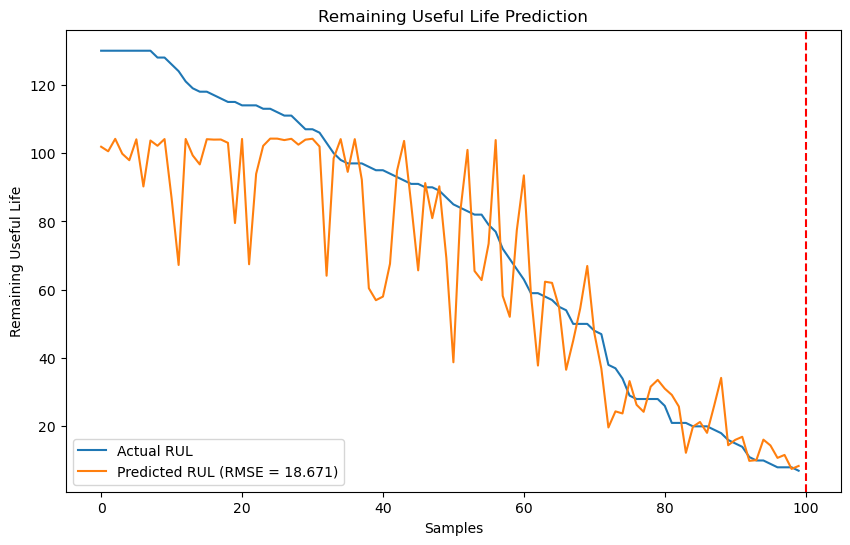